## Text classification - Movie reviews

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of binary classification.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import pandas as pd

## Download the IMDB datasets

The IMDB reviews dataset comes packaged in tensorflow_datasets package. It has already been preprocessed so that the reviews (sequence of words) have been converted to sequence of integers, which each integer represets a specific word in a dictionary.

In [2]:
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k",
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised = True,
    with_info = True
)

Shuffling and writing examples to C:\Users\Ridzuan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete32E1RI\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\Ridzuan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete32E1RI\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\Ridzuan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete32E1RI\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\Ridzuan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features["text"].encoder

print("Vocabulary size : {}".format(encoder.vocab_size))

Vocabulary size : 8185


In [8]:
sample_string = "Hello TensorFlow."

# try encode the sample string using given encoder
encoded_string = encoder.encode(sample_string)
print("Encoded string: {} \n".format(encoded_string))

# try decode the sample string using given encoder
decoded_string = encoder.decode(encoded_string)
print("Decoded string: {} \n".format(decoded_string))

assert decoded_string == sample_string

Encoded string: [4025, 222, 6307, 2327, 4043, 2120, 7975] 

Decoded string: Hello TensorFlow. 



The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resemble the dataset, the shorter the representation will be.

In [12]:
for subword in encoded_string:
    print("{} ----> {}".format(subword, encoder.decode([subword])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Exploring the data

Since the datasets come preprocessed, each example is an array of integers, where each integer represents a specific word-piece in the dictionary.

Each label is an integer value of either 0 or 1, where 0 is a negative review and 1 is a positive review.

In [18]:
for train_example, train_label in train_data.take(1):
    print("Encoded text: \n", train_example[:10].numpy())
    print("Decoded text: \n", encoder.decode(train_example[:10].numpy()))
    print("Label: \n", train_label.numpy())

Encoded text: 
 [  62    9    4  301 4161  267  148    1 3240 1779]
Decoded text: 
 This is a big step down after the surprisingly enjoyable 
Label: 
 0


In [20]:
encoder.decode(train_example)

'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.'

## Data preprocessing before training

Batches will be created for training the model. Since the reviews are all in different length, ```padded batch``` will be used to zero pad the sequence while batching.

In [22]:
BUFFER_SIZE = 100

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes)
)

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes)
)

Each batch will have shape of ```(batch_size, sequence_length)``` because the padding is dynamic each batch will have different length.

In [24]:
for example_batch, label_batch in train_batches.take(2):
    print("Batch shape: ", example_batch.shape)
    print("Label shape: ", label_batch.shape)

Batch shape:  (32, 1323)
Label shape:  (32,)
Batch shape:  (32, 1114)
Label shape:  (32,)


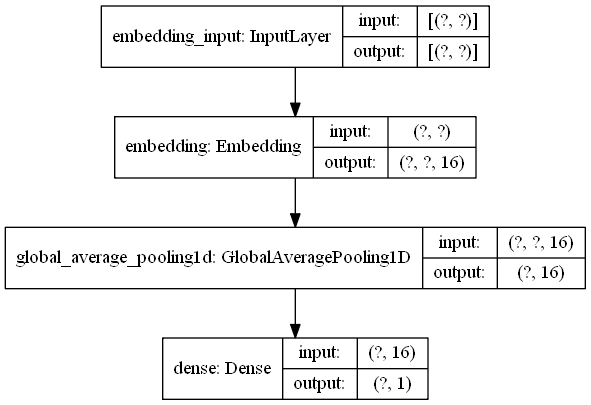

In [32]:
from tensorflow.keras.utils import plot_model
import os

model = keras.Sequential([
          keras.layers.Embedding(encoder.vocab_size, 16),
          keras.layers.GlobalAveragePooling1D(),
          keras.layers.Dense(1, activation='sigmoid')
        ])

# add Grpahwiz to path variable
os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphviz2.38/bin/"

plot_model(
    model,
    show_shapes = True,
    expand_nested = True
)

- First layer is an ```embedding``` layer. This layer takes the integer encoded vocabulary and looks up the embedding vector for each word index. These vectors are learned as the model trains. The vectors add a dimension to the output tray. The resulting dimension will be ```(batch, sequence, embedding)```
- ```GlobalAveragePooling1D``` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
- Fixed-length output vecto is piped through a ```Dense``` layer with 16 hidden unit.
- Last layer is connected into single output with activation function of ```sigmoid``` where the output value ranges from *0* to *1*, representing confidence level of the prediction.

## Loss function and optimized

Since this is a binary classification problem and the model output a probability using a ```sigmoid``` function, ```binary_crossentropy``` will be used as a loss function.

Other alternative would be ```mean_squared_error```, but generally ```binary_crossentropy``` is better for dealing with probabilities as it measures the distance between probability distribution, or in this case, between ground-truth distribution and the predictions.

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
            train_batches,
            epochs=10,
            validation_data=test_batches,
            validation_steps=30)

Epoch 1/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6824 - accuracy: 0.6362 - val_loss: 0.6635 - val_accuracy: 0.7688
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6215 - accuracy: 0.7512 - val_loss: 0.5919 - val_accuracy: 0.7906
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.5436 - accuracy: 0.8060 - val_loss: 0.5299 - val_accuracy: 0.8135
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4759 - accuracy: 0.8402 - val_loss: 0.4832 - val_accuracy: 0.8417
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4229 - accuracy: 0.8633 - val_loss: 0.4489 - val_accuracy: 0.8510
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3829 - accuracy: 0.8770 - val_loss: 0.4241 - val_accuracy: 0.8573
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3497 - accuracy: 0.8861 - val_loss: 0.4064 - val_accuracy: 0.8604
E

In [34]:
loss, accuracy = model.evaluate(test_batches)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 4s 5ms/step - loss: 0.3339 - accuracy: 0.8759- 3s - 4s 5ms/step - loss: 0.3327 - accuracy - 4s 5ms/stLoss:  0.3339002385945119
Accuracy:  0.87588


In [36]:
history_dict = history.history
pd.DataFrame(history_dict.keys())

,0
0,loss
1,accuracy
2,val_loss
3,val_accuracy


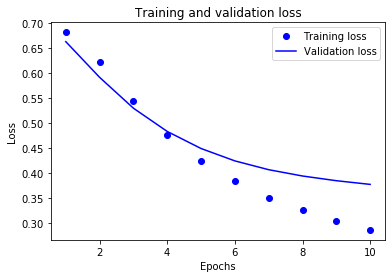

In [37]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

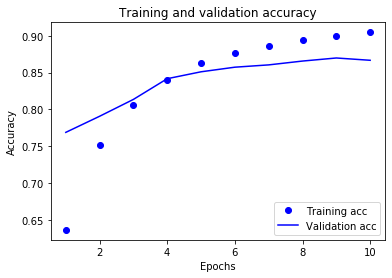

In [38]:
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()